<a href="https://colab.research.google.com/github/ErickMM98/covid-ct-network-analysis/blob/main/covid_mfdfa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargamos los datos.



In [1]:
!mkdir data
!mkdir data/covid
!mkdir data/normal

In [2]:
#@title For COVID Cases
!wget http://ncov-ai.big.ac.cn/download/COVID19-27.zip

--2021-09-21 07:02:57--  http://ncov-ai.big.ac.cn/download/COVID19-27.zip
Resolving ncov-ai.big.ac.cn (ncov-ai.big.ac.cn)... 124.16.164.43
Connecting to ncov-ai.big.ac.cn (ncov-ai.big.ac.cn)|124.16.164.43|:80... connected.
HTTP request sent, awaiting response... 200 
Length: 79485632 (76M) [application/octet-stream]
Saving to: ‘COVID19-27.zip’

COVID19-27.zip      100%[===================>]  75.80M   373KB/s    in 3m 32s  

2021-09-21 07:06:29 (367 KB/s) - ‘COVID19-27.zip’ saved [79485632/79485632]



In [3]:
#@title For normal cases
!wget http://ncov-ai.big.ac.cn/download/Normal-8.zip

--2021-09-21 07:06:29--  http://ncov-ai.big.ac.cn/download/Normal-8.zip
Resolving ncov-ai.big.ac.cn (ncov-ai.big.ac.cn)... 124.16.164.43
Connecting to ncov-ai.big.ac.cn (ncov-ai.big.ac.cn)|124.16.164.43|:80... connected.
HTTP request sent, awaiting response... 200 
Length: 89250877 (85M) [application/octet-stream]
Saving to: ‘Normal-8.zip’

Normal-8.zip        100%[===================>]  85.12M   318KB/s    in 4m 38s  

2021-09-21 07:11:09 (314 KB/s) - ‘Normal-8.zip’ saved [89250877/89250877]



In [4]:
!unzip COVID19-27.zip -d data/covid
!unzip Normal-8.zip -d data/normal

Streaming output truncated to the last 5000 lines.
  inflating: data/covid/NCP/1050/2624/0213.JPG  
  inflating: data/covid/NCP/1050/2624/0073.JPG  
  inflating: data/covid/NCP/1050/2624/0133.JPG  
  inflating: data/covid/NCP/1050/2624/0081.JPG  
  inflating: data/covid/NCP/1050/2624/0068.JPG  
  inflating: data/covid/NCP/1050/2624/0428.JPG  
  inflating: data/covid/NCP/1050/2624/0193.JPG  
  inflating: data/covid/NCP/1050/2624/0185.JPG  
  inflating: data/covid/NCP/1050/2624/0118.JPG  
  inflating: data/covid/NCP/1050/2624/0147.JPG  
  inflating: data/covid/NCP/1050/2624/0092.JPG  
  inflating: data/covid/NCP/1050/2624/0364.JPG  
  inflating: data/covid/NCP/1050/2624/0178.JPG  
  inflating: data/covid/NCP/1050/2624/0187.JPG  
  inflating: data/covid/NCP/1050/2624/0341.JPG  
  inflating: data/covid/NCP/1050/2624/0204.JPG  
  inflating: data/covid/NCP/1050/2624/0356.JPG  
  inflating: data/covid/NCP/1050/2624/0385.JPG  
  inflating: data/covid/NCP/1050/2624/0265.JPG  
  inflating: data/

In [59]:
#@title Algunas dependencias de Python
from tqdm.auto import tqdm

# Presentamos MF-DFA

Particionamos la imagen a cuadros de longitud $s$.

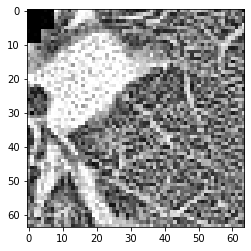

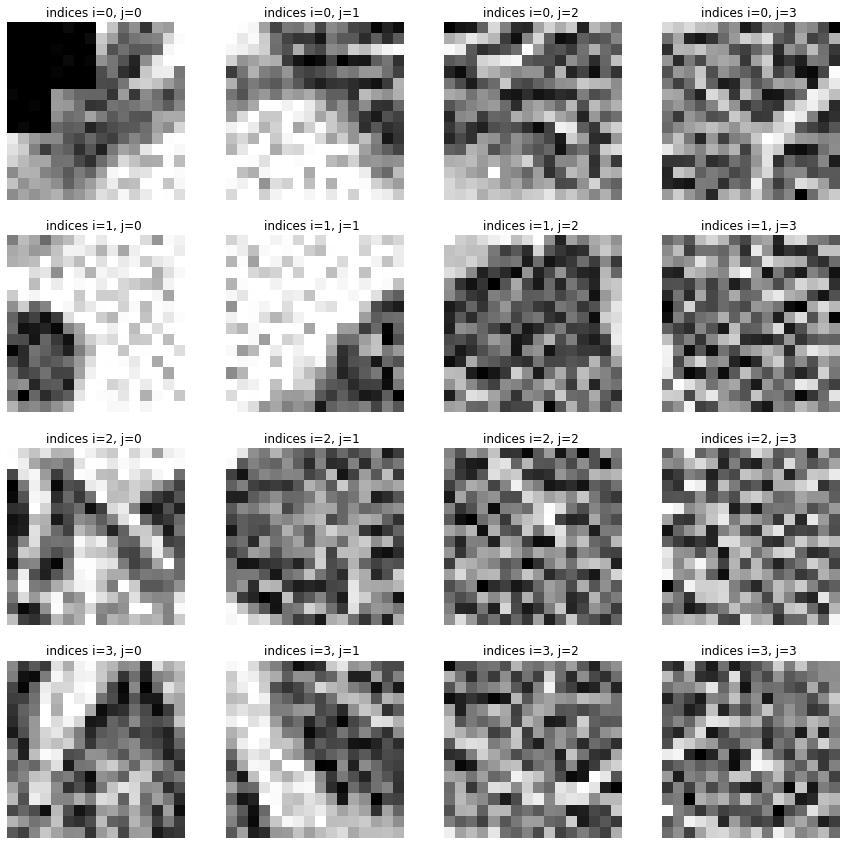

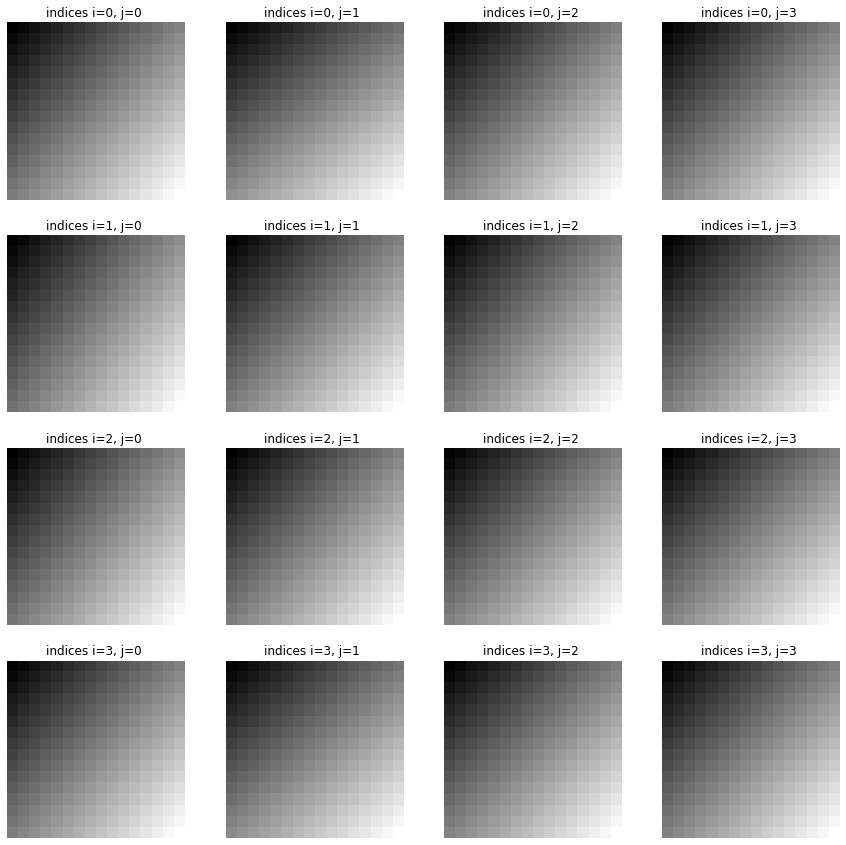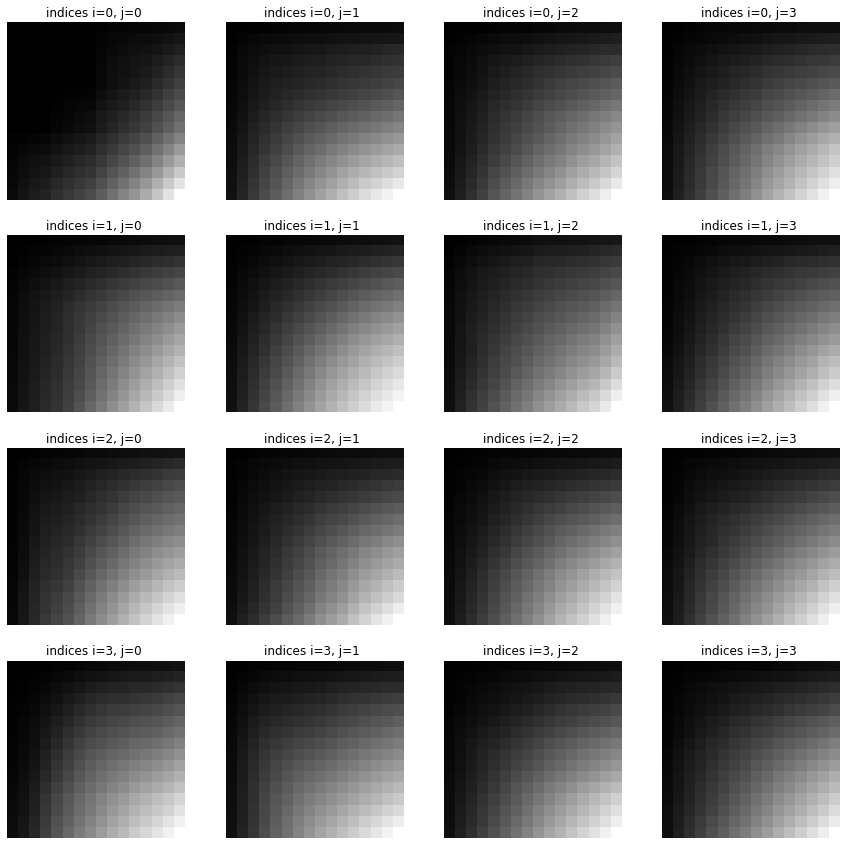

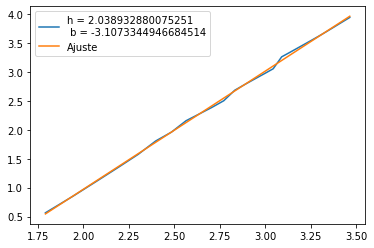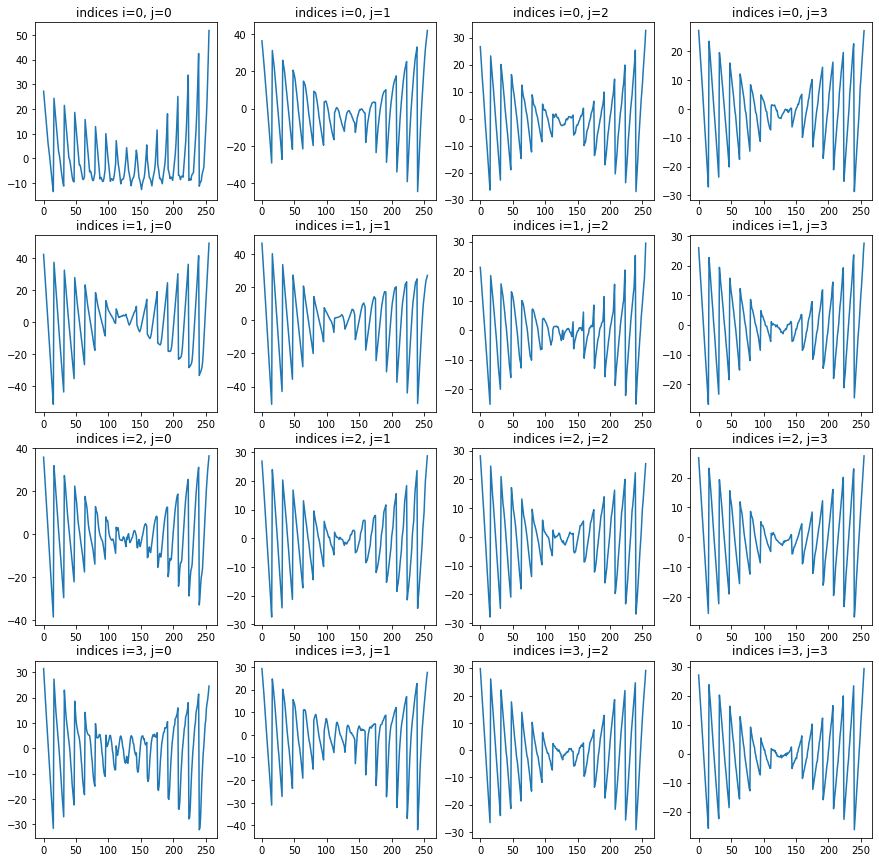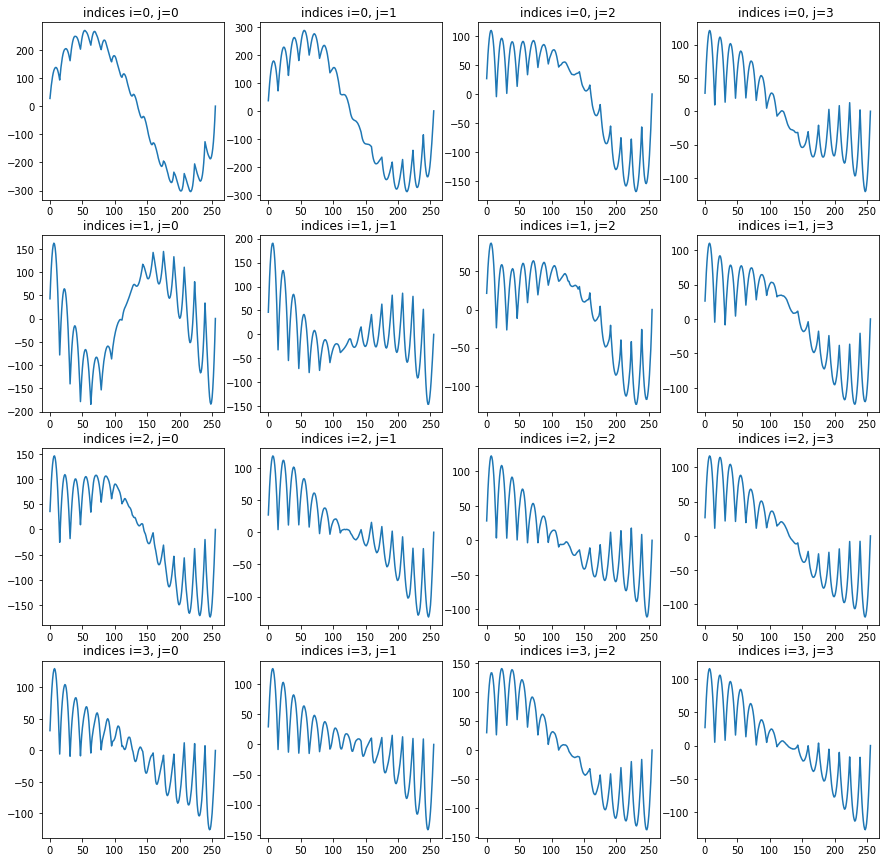

# Codigo

In [60]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 13 16:12:49 2021

@author: Erick Muñiz Morales

Modules to image segmentation by multifractal detrendted
fluctiation analysis. 


"""

import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import os
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist

str_path_covid = 'data/foo_image/covid.JPG'


"""
------- BEGIN MODULAR FUNCTIONS
"""

def get_windows_size_w_by_pixel(img, i,j,w=11):
    """
    

    Parameters
    ----------
    img : TYPE
        DESCRIPTION.
    i : TYPE
        DESCRIPTION.
    j : TYPE
        DESCRIPTION.
    w : TYPE, optional
        DESCRIPTION. The default is 11.

    Returns
    -------
    TYPE
        DESCRIPTION.

    """
    N = img.shape[0]
    M = img.shape[1]
    min_x = max([ i-w, 0 ])
    max_x = min([ i+w, N ])
    
    min_y = max([ i-w, 0 ])
    max_y = min([ i+w, M ])
    
    return img[min_x:max_x, min_y:max_y]
    

def get_window_size_s(img,i,j,s):
    """
    Parameters
    ----------
    img : skimae.io.imread (ndarray); the whole image
        the whole image
    s : size of the window of fluctiation
        DESCRIPTION.
    i : row index
        is less of N_s
    j : column index
        is less of M_s

    Returns
    -------
    TYPE
        The image window of size s with index i,j in the new fluctuation.

    """
    min_x = i*s
    max_x = (i+1)*s
    min_y = j*s
    max_y = (j+1)*s
    return img[min_x:max_x, min_y:max_y]

def get_cumulative_matrix(img):
    """
    Get the sum cumulative matrix of the squared matrix (img).

    Parameters
    ----------
    img : Matrix of values.
        DESCRIPTION.

    Returns
    -------
    None.

    """
    N = img.shape[0]
    
    matrix_ones = np.ones((N,N))
    
    rigth_matrix = np.triu(matrix_ones)
    left_matrix = np.tril(matrix_ones)
    
    return left_matrix @ img @ rigth_matrix
    
def make_var_least_squared_cum_matrix(cum_matrix, vectors = False):
    """
    A linear regresion of the window

    Parameters
    ----------
    cum_matrix : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    """
    
    N = cum_matrix.shape[0]
    
    A = []
    y = []
    for i in range(N):
        for j in range(N):
            renglon = [i+1,j+1,1]
            A.append(renglon)
            y.append([cum_matrix[i,j]])
            
    A = np.array(A)
    y = np.array(y)
    #print(A,y)
    alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    
    y_pred = A @ alpha
    y_real = y
    
    if vectors:
        return y_real.ravel(), y_pred.ravel(), y_pred.reshape((N,N))
    else:
        return np.mean((y_real.ravel() - y_pred.ravel())**2)

def measure_fractal(array_var, q = 2):
    """
    For the other measures. 

    Parameters
    ----------
    array_var : TYPE
        DESCRIPTION.
    q : TYPE, optional
        DESCRIPTION. The default is 2.

    Returns
    -------
    None.

    """
    array_var = np.array(array_var)
    return np.mean( array_var**(q/2) )**(1/q)


def get_leas_squared_array(x,y):
    """
    The most simple least squered of two arrays. The model is in the form
                y = ax + b
    Parameters
    ----------
    x : TYPE
        DESCRIPTION.
    y : TYPE
        DESCRIPTION.

    Returns 
    -------
    a,b in the above formula.

    """
    
    x = np.array(x).reshape((len(x),1))
    y = np.array(y).reshape((len(y),1))
    A = np.concatenate( [x, np.ones((x.shape[0],1))] , axis=1)

    
    h = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    
    return h.ravel()


"""
------- END MODULAR FUNCTIONS
"""

"""
------- BEGIN PRINCIPAL FUNCTIONS
"""

def make_mfdfa_individual_window(window, s, q=2):
    """
    

    Parameters
    ----------
    window : TYPE
        DESCRIPTION.
    s : TYPE
        DESCRIPTION.
    q : TYPE, optional
        DESCRIPTION. The default is 2.

    Returns
    -------
    Fluctuation

    """
    
    N,M = window.shape
    
    N_s = int(N / s)
    M_s = int(M / s)
    
    #fig,ax = plt.subplots()
    #ax.imshow(window, cmap = 'gray')
    
    #fig, axes = plt.subplots(4,4)
    #fig.set_size_inches([15,15])
    #ax = axes.ravel()
    
    #k = 0
    
    #ESTO ES LO QUE SE PUEDE PARALELIZAR
    
    F_list_q = []
    for i in range(N_s):
        for j in range(M_s):
            X_mn = get_window_size_s(window, i, j, s)
            
            G_mn = get_cumulative_matrix(X_mn)
            
            y_real, y_pred, G_mn_pred = make_var_least_squared_cum_matrix(G_mn, vectors=True)
            
            y_mn = y_real - y_pred
            
            f_2mn = np.mean(y_mn**2)
            
            F_list_q.append(f_2mn)
            
            #ax[k].set_title("indices i={}, j={} ".format(i,j))
            #ax[k].imshow(G_mn_pred, cmap = 'gray' )
            #ax[k].plot(range(len(y_mn)),np.cumsum(y_mn), label = '{}'.format(f_2mn))
            #ax[k].legend()
            #ax[k].axis(False)
            
            #k +=1
            
    F_q = np.mean(np.array(F_list_q)**(q/2))**(1/q)
    
    #print(F_q)
    
    return F_q


def get_h_q_mfdfa(window, min_s = 6, max_s = None, q = 2):
    """
    Esta es la que debemos paralelizar    

    Parameters
    ----------
    window : TYPE
        DESCRIPTION.
    min_s : TYPE, optional
        DESCRIPTION. The default is 6.
    max_s : TYPE, optional
        DESCRIPTION. The default is None.
    q : TYPE, optional
        DESCRIPTION. The default is 2.

    Returns
    -------
    None.

    """
    s_ls = None
    y_ls = []
    
    N,M = window.shape
    
    if max_s == None:
        s_ls = range(min_s, int(min([N,M])/2) + 1 ,2)
    else:
        s_ls = range(min_s, max_s + 1 )
    
    for s in s_ls:
        #print(s)
        h = make_mfdfa_individual_window(window,s=s, q = 2)
        y_ls.append(h)
        
    h_q = get_leas_squared_array(np.log(s_ls), np.log(y_ls))
    
    return h_q[0]

def mfdfa_q_s(img, min_s = 6, max_s = None, q = 2, w= 16):
    """
    Function to get the image with the h value for each pixel. 

    Parameters
    ----------
    img : TYPE
        DESCRIPTION.
    min_s : TYPE, optional
        DESCRIPTION. The default is 6.
    max_s : TYPE, optional
        DESCRIPTION. The default is None.
    q : TYPE, optional
        DESCRIPTION. The default is 2.
    w : TYPE, optional
        DESCRIPTION. The default is 16.

    Returns
    -------
    None.

    """
    
    N,M = img.shape
    
    img_h = np.zeros( (N,M) )
    
    
    for ip in tqdm(range(N),desc='Progress'):
        for jp in range(M):
            if img[ip,jp] > 0:
                img_h[ip,jp] = 1
                window_pixel = get_windows_size_w_by_pixel(img,ip,jp,w=w)
                h_value = get_h_q_mfdfa(window_pixel,
                                    min_s=min_s,
                                    max_s=max_s,
                                    q = q)
                if h_value > 0:
                    img_h[ip,jp] = h_value
                else:
                    img_h[ip,jp] = 0
            else:
                img_h[ip,jp] = 0
    
    return img_h

#"""
#------- END PRINCIPAL FUNCTIONS
#"""

def get_h_image(img, q = 2):
    """
    

    Parameters
    ----------
    img : TYPE
        DESCRIPTION.
    q : TYPE, optional
        DESCRIPTION. The default is 2.

    Returns
    -------
    None.

    """
    
    s_ls = range(6, 17 + 1 )
    y_ls = []
    for s in s_ls:
        #print(s)
        h = make_mfdfa_individual_window(img,s=s, q = 2)
        y_ls.append(h)
        
    h_q = get_leas_squared_array(np.log(s_ls), np.log(y_ls))
    
    return h_q[0]

In [ ]:
path_covid_patients = 'data/covid/NCP/'
path_normal_patients = 'data/normal/Normal/'

list_id_pat = os.listdir(path_covid_patients)

In [ ]:
from skimage import io
from natsort import natsorted, ns
#moon = io.imread(filename)
list_frame = []
for folder in os.listdir(path_covid_patients + list_id_pat[9])[0:1]:
  for image in natsorted(os.listdir(path_covid_patients + list_id_pat[9] + '/' + folder)[:]):
    img = io.imread( path_covid_patients + list_id_pat[9] + '/' + folder +'/' + image)
    list_frame.append(img)

#Prueba para COVID

In [ ]:
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist


covid_foo = []

for i in tqdm(range(len(list_frame))[30:50]):
  img = list_frame[i]
  #primero equalizamos 
  foo_img = equalize_adapthist(img, clip_limit=0.02)

  val = get_h_image(foo_img)
  print(val)
  covid_foo.append(val)



#img = list_frame[18]#[200:264,120:184]

#foo_img = mfdfa_q_s(img,min_s= 2, max_s = 6, w=5)

  0%|          | 0/20 [00:00<?, ?it/s]

1.9740846907867156
1.9707226683260894
1.9725129027317232
1.9764471508192663
1.9723771345873269
1.9672191135984542
1.9740414309869496
1.969939127973124
1.9717629057114183
1.9716744755892965
1.9709865211891702
1.9715148680868078
1.9717653496484484
1.9713222660281817
1.9752506161228764
1.978893204877136
1.982783901402435
1.97398281853113
1.9747776145622242
1.9743519025945866


# Prueba para persona normal

In [ ]:
path_normal_patients = 'data/normal/Normal/'

list_id_pat = os.listdir(path_normal_patients)

list_frame = []
for folder in os.listdir(path_normal_patients + list_id_pat[0])[0:1]:
  for image in natsorted(os.listdir(path_normal_patients + list_id_pat[0] + '/' + folder)[:]):
    img = io.imread( path_normal_patients + list_id_pat[0] + '/' + folder +'/' + image)
    list_frame.append(img)

In [ ]:
normal_foo = []

for i in tqdm(range(len(list_frame))[30:50]):
  img = list_frame[i]
  #primero equalizamos 
  foo_img = equalize_adapthist(img, clip_limit=0.02)

  val = get_h_image(foo_img)
  print(val)
  normal_foo.append(val)

  0%|          | 0/20 [00:00<?, ?it/s]

1.9856748066826775
1.9846426555995704
1.9836951001043448
1.9807475759891449
1.9792055946215763
1.9793154089152145
1.9824362760775192
1.983966595635689
1.9874403693365403
1.9841567822307937
1.9852416323163065
1.9818369437176482
1.9758368787865492
1.974294756811606
1.974802424982548
1.9755940104301115
1.9738567129211666
1.9789148780515726
1.9841126717126285
1.9801039367453315


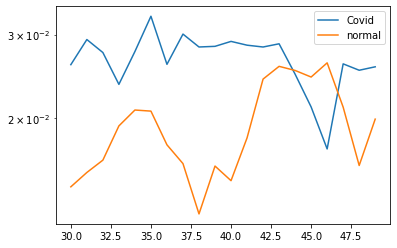

In [ ]:
covid_foo_foo = np.array(covid_foo)
normal_foo_foo = np.array(normal_foo)

fig, ax = plt.subplots()

ax.plot( range(30,50), 2-covid_foo_foo, label= 'Covid')
ax.plot( range(30,50), 2-normal_foo_foo, label= 'normal')
ax.set_yscale('log')
ax.legend()

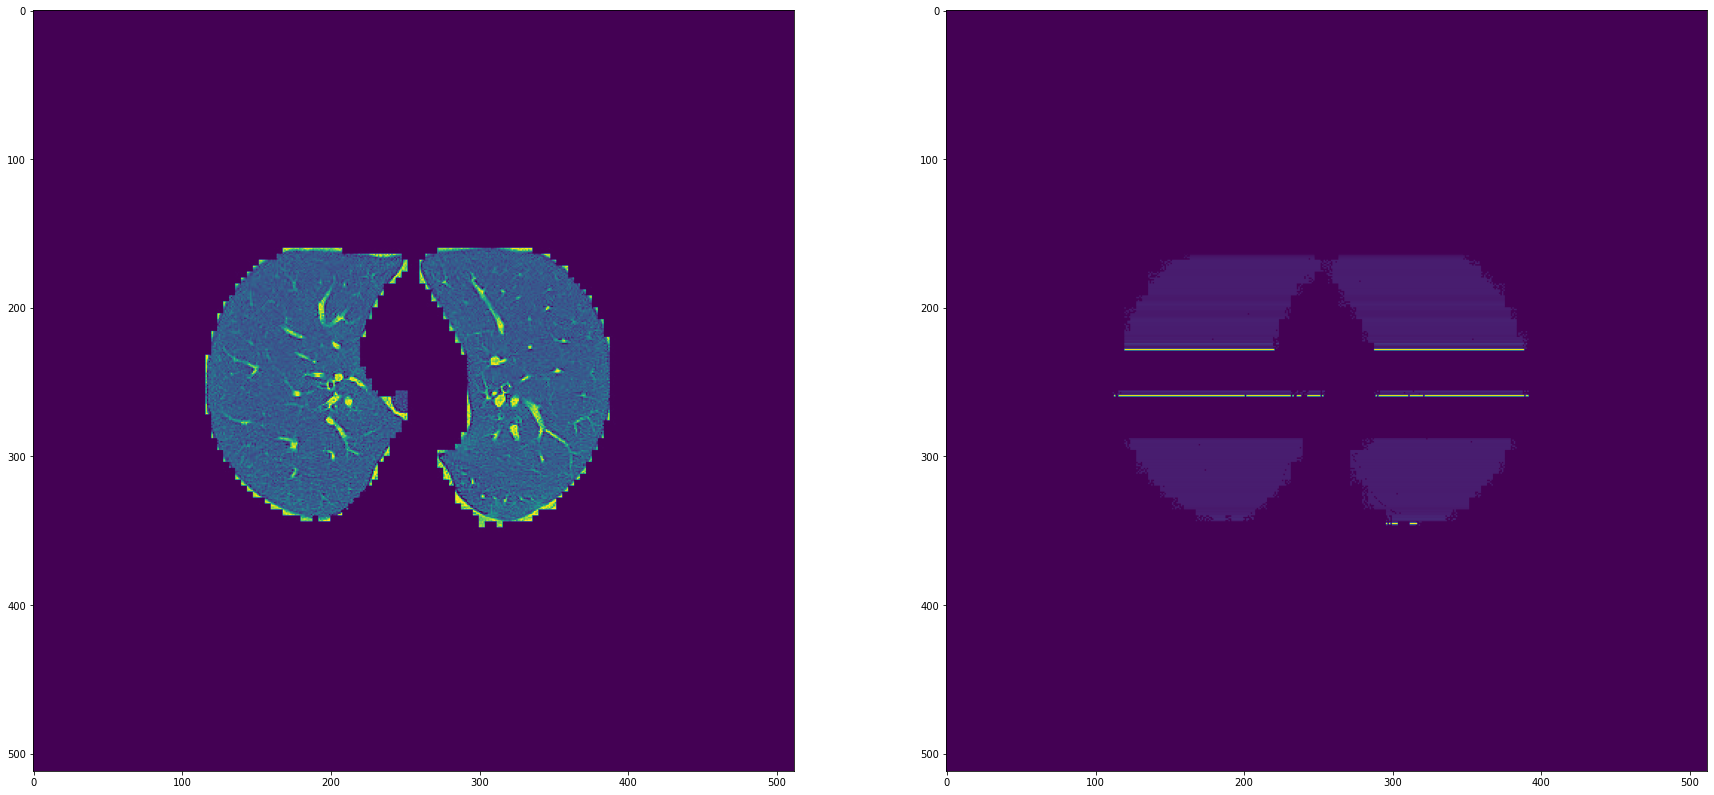

In [ ]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches([30,30])
ax = axes.ravel()

ax[0].imshow(img)
ax[1].imshow(foo_img)

# Sobre CUDA

In [ ]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/lib/python3.7/dist-packages/jaxlib/cuda/nvvm/libdevice
/usr/local/cuda-11.1/nvvm/libdevice
/usr/local/cuda-11.0/nvvm/libdevice
/usr/local/cuda-10.1/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/libdevice
/usr/local/cuda-11.1/nvvm/lib64/libnvvm.so
/usr/local/cuda-11.0/nvvm/lib64/libnvvm.so
/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so


In [ ]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-11.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-11.0/nvvm/lib64/libnvvm.so"

In [ ]:
from numba import cuda
import numba
print(cuda.gpus)

<Managed Device 0>


In [ ]:
from numba import jit
import numpy as np

@jit(nopython=True) 
def matrix_cum_sum_fast(mat):
  """
  qweqwe
  """ 
  N,_ = mat.shape
  ones = np.ones((N,N)).reshape(N,N)
  lower_ones = np.tril(ones)
  uper_ones = lower_ones.T
  result = lower_ones @ mat @ uper_ones
  return result


def matrix_cum_sum_slow(mat):
  """
  qweqwe
  """ 
  N,_ = mat.shape
  ones = np.ones((N,N)).reshape(N,N)
  lower_ones = np.tril(ones)
  uper_ones = lower_ones.T
  return lower_ones @ mat @ uper_ones

In [ ]:
n = 100
mat = np.random.normal( size = n**2).reshape(n,n)

In [ ]:
%%time 
matrix_cum_sum_slow(mat)
print("terminé")

terminé
CPU times: user 1.39 ms, sys: 1.98 ms, total: 3.38 ms
Wall time: 2.93 ms


In [ ]:
%%time 
matrix_cum_sum_fast(mat)
print("terminé")

terminé
CPU times: user 2.61 ms, sys: 991 µs, total: 3.6 ms
Wall time: 4.62 ms


# PRUEBAS -------------------------------

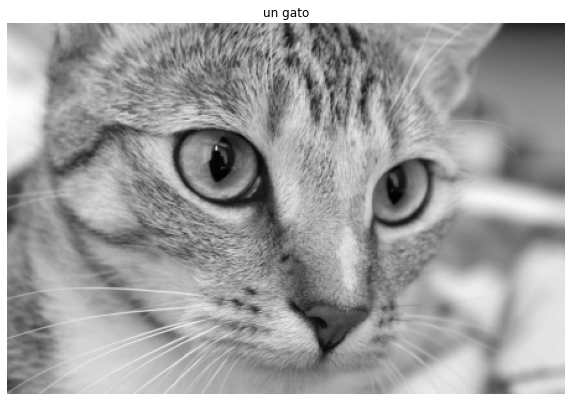

In [150]:
from skimage import data
import matplotlib.pyplot as plt
from skimage import color
cat = color.rgb2gray( data.chelsea()  )

fig, ax = plt.subplots()
fig.set_size_inches([10,10])
ax.imshow(cat, cmap = 'gray')
ax.set_title("un gato")
ax.axis(False)

pass

  0%|          | 0/80 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


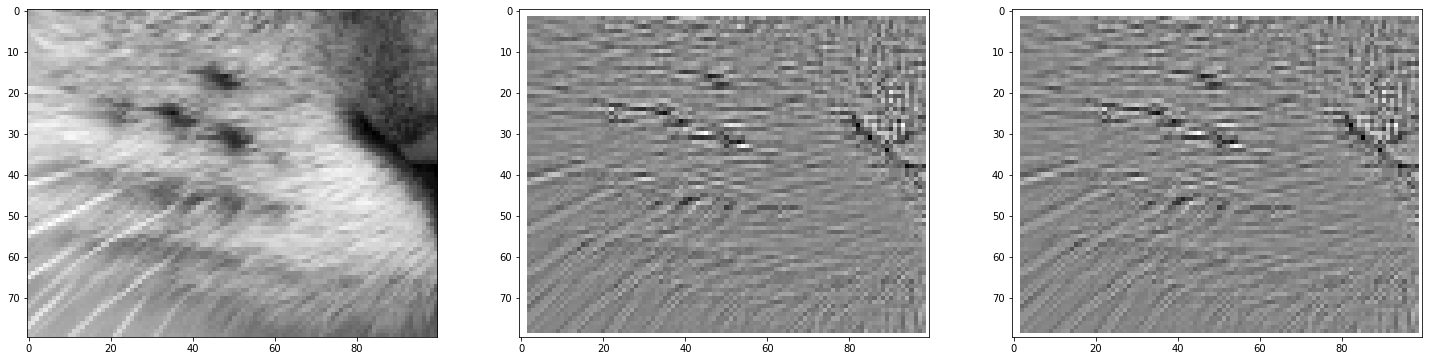

In [151]:
foo_cat = cat[ 200:280 , 150:250]
N, M = foo_cat.shape
w = 2
n , m = N,M
final_img_q10 = np.zeros( (n,m) )
final_img_2 = np.zeros( (n,m) )
for i in tqdm(range(N)[0:n]):
  for j in range(M)[0:m]:
    min_x = max( [i - w , 0] )
    max_x = min( [i + w , N] )
    min_y = max( [j - w , 0] )
    max_y = min( [j + w , M] )
    #fig, ax = plt.subplots()
    #ax.imshow(foo_cat[ min_x:max_x , min_y:max_y])

    h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=-10)
    h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=2)
    final_img_q10[i,j] = h_10
    final_img_2[i,j] = h_2
    #ax.set_title("i = {}, j = {}".format(i,j))

fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,25])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[1].imshow(final_img_q10, cmap ='gray')
ax[2].imshow(final_img_2, cmap ='gray')
#ax.set_title("ALL")

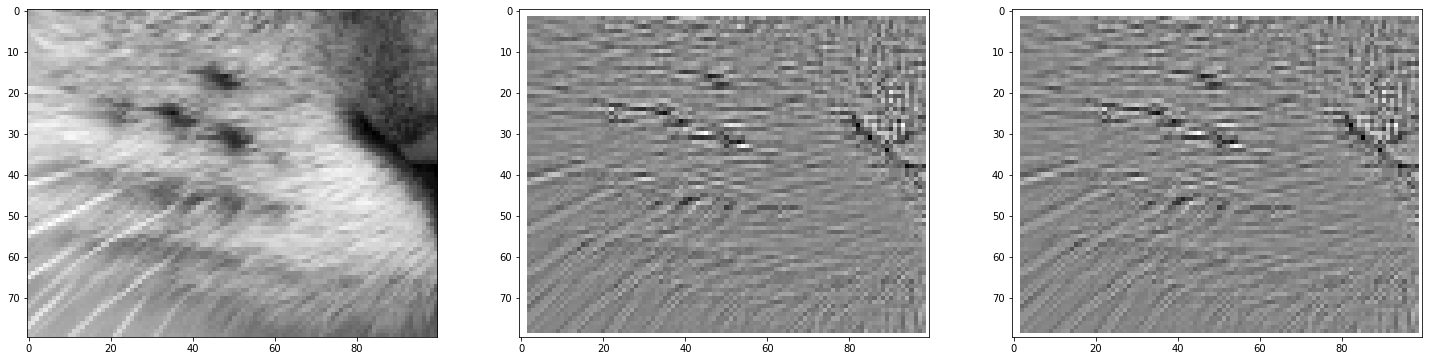

In [123]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,25])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[1].imshow( final_img_q10 , cmap ='gray')
ax[2].imshow(final_img_2, cmap ='gray')

nan nan


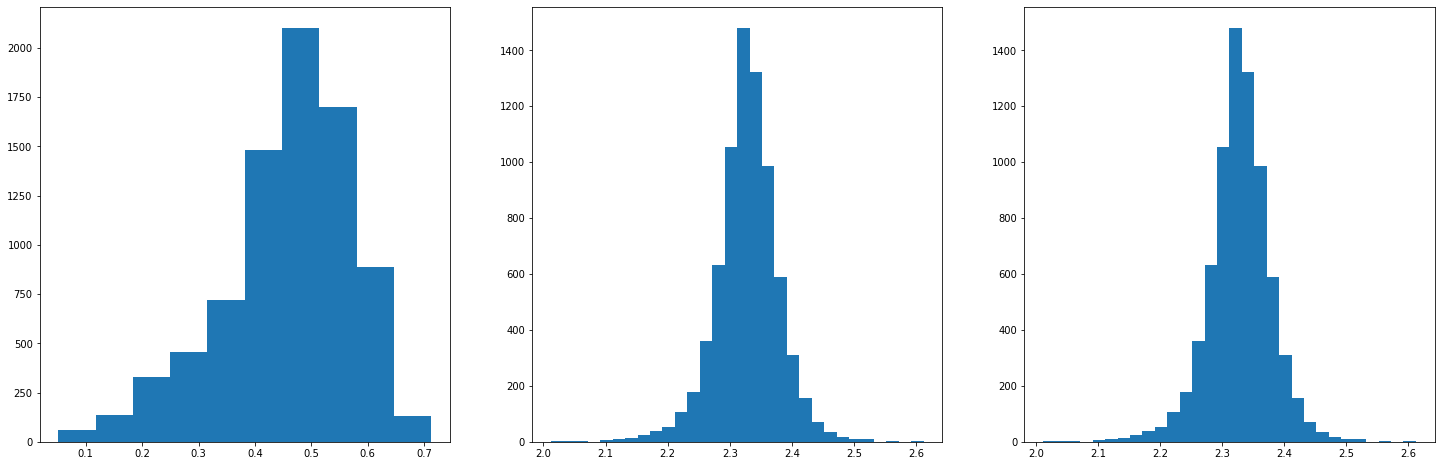

In [124]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,8])
ax = axes.ravel()
ax[0].hist(foo_cat.ravel())
ax[1].hist(final_img_q10.ravel(), bins = 30)
ax[2].hist(final_img_2.ravel(), bins = 30)
pass

print( np.mean(final_img_q10.ravel() ), np.mean(final_img_2.ravel() ))

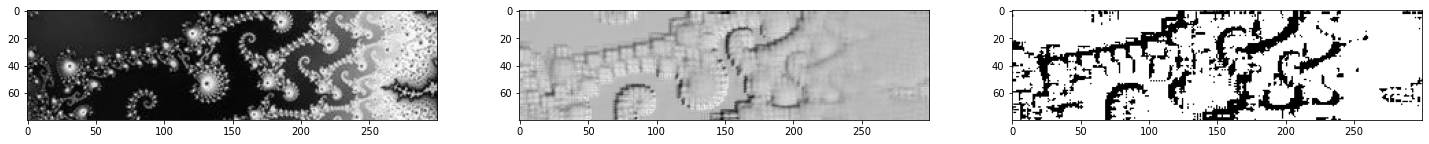

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,25])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[1].imshow( final_img_q10 , cmap ='gray')
ax[2].imshow( final_img_q10 > 2.2, cmap ='gray')

(array([262104.,  65683.,  50379.,  47897.,  45137.,  41145.,  55297.,
         45285.,  64252.,  52869.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

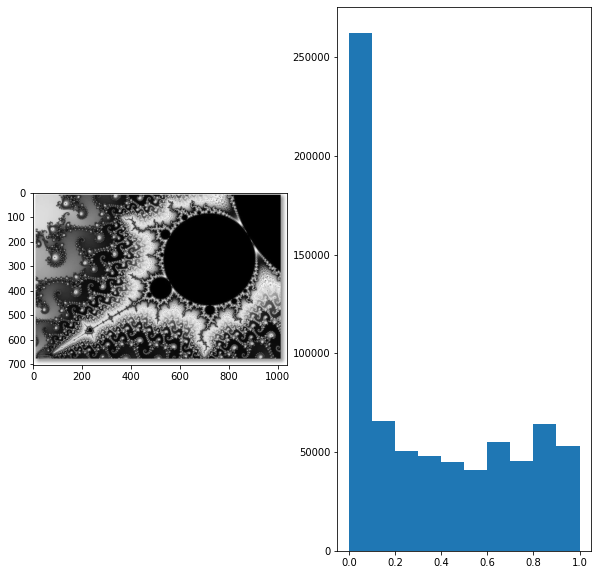

In [100]:
#@title Fractal de prueba

from skimage.io import imread
from skimage import color
#cat = color.rgb2gray( data.chelsea()  )
fractal = imread("https://m.media-amazon.com/images/I/81ep2kZdU-L._AC_SL1100_.jpg")
fractal = color.rgb2gray(fractal)
fig, axes = plt.subplots(1,2)
fig.set_size_inches([10,10])
ax = axes.ravel()
ax[0].imshow(fractal, cmap = 'gray')
ax[1].hist(fractal.ravel())
#ax.set_title("un fractal")
#ax.axis(False)


  0%|          | 0/80 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 1min 1s, sys: 50.1 s, total: 1min 51s
Wall time: 58.4 s


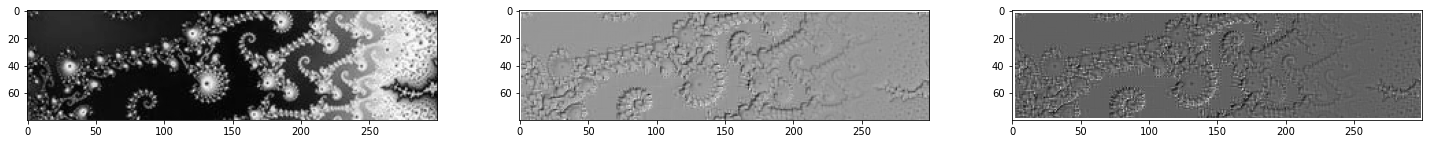

In [103]:
%%time
foo_cat = fractal[ 200:280 , 200:500]
N, M = foo_cat.shape
w = 2
n , m = N,M
final_img_q10 = np.zeros( (n,m) )
final_img_2 = np.zeros( (n,m) )
for i in tqdm(range(N)[0:n]):
  for j in range(M)[0:m]:
    min_x = max( [i - w , 0] )
    max_x = min( [i + w , N] )
    min_y = max( [j - w , 0] )
    max_y = min( [j + w , M] )
    #fig, ax = plt.subplots()
    #ax.imshow(foo_cat[ min_x:max_x , min_y:max_y])

    h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=3,q=-10)
    h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=2)
    final_img_q10[i,j] = h_10
    final_img_2[i,j] = h_2

    #ax.set_title("i = {}, j = {}".format(i,j))

fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,40])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[1].imshow(final_img_q10, cmap ='gray')
ax[2].imshow(final_img_2, cmap ='gray')

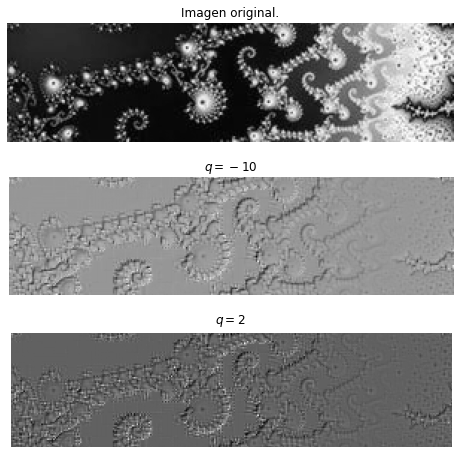

In [118]:
fig, axes = plt.subplots(3,1)
fig.set_size_inches([8,8])
ax = axes.ravel()

ax[0].imshow(foo_cat,cmap ='gray')
ax[0].set_title("Imagen original.")
ax[1].imshow(final_img_q10, cmap ='gray')
ax[1].set_title("$q = -10$")
ax[2].imshow(final_img_2, cmap ='gray')
ax[2].set_title("$q = 2$")
ax[0].axis(False)
ax[1].axis(False)
ax[2].axis(False)
fig.savefig("Mandelbrotset.pdf")

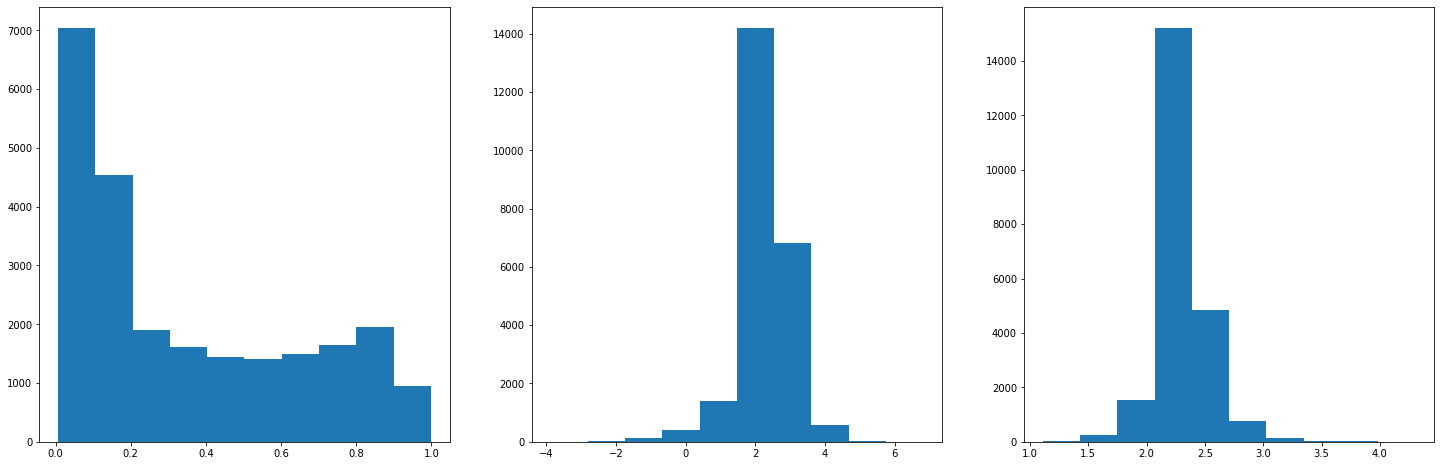

In [105]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,8])
ax = axes.ravel()
ax[0].hist(foo_cat.ravel())
ax[1].hist(final_img_q10.ravel())
ax[2].hist(final_img_2.ravel())
pass

In [ ]:
#def count_box_interval(array_values, max_n = 100):
  

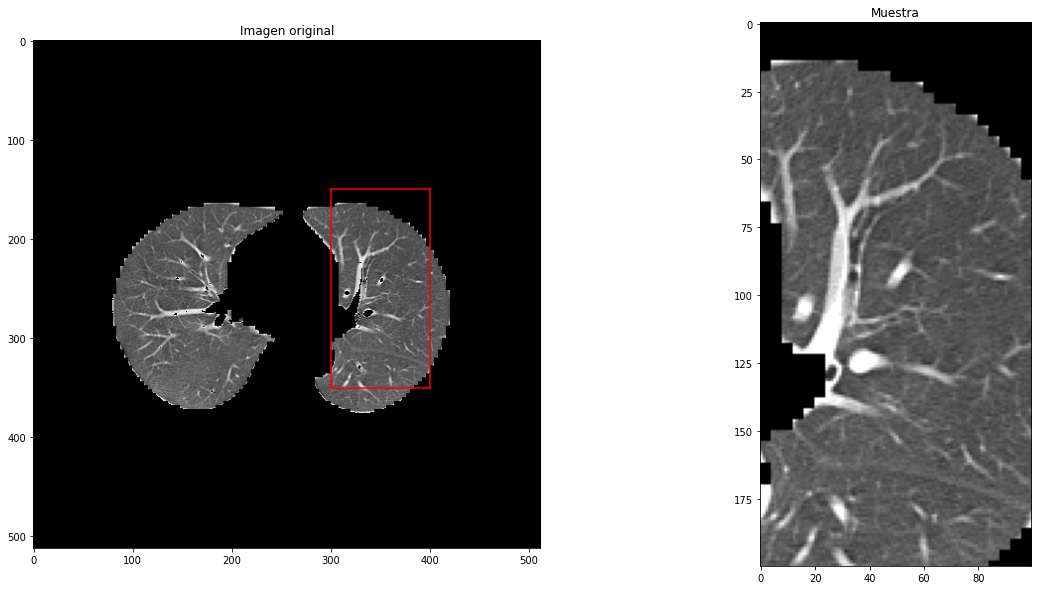

In [148]:
#@title Fractal de prueba

from skimage.io import imread
from skimage.exposure import equalize_adapthist
sample_min_x = 150
sample_max_x = 350
sample_min_y = 300
sample_max_y = 400
#cat = color.rgb2gray( data.chelsea()  )
#fractal = imread("/content/data/normal/Normal/1867/322/0043.png", as_gray=True)
#Con CVODI
fractal = imread("/content/data/covid/NCP/179/1503/0021.png", as_gray=True)

#fractal = color.rgb2gray(fractal)
fig, axes = plt.subplots(1,2)
ax = axes.ravel()
fig.set_size_inches([20,10])
ax[0].imshow(fractal + 1, cmap = 'gray')
ax[0].plot([sample_min_y, sample_max_y],
           [sample_max_x, sample_max_x],
           color='red')
ax[0].plot([sample_min_y, sample_max_y],
           [sample_min_x, sample_min_x],
           color='red')
ax[0].plot([sample_min_y, sample_min_y],
           [sample_min_x, sample_max_x],
           color='red')
ax[0].plot([sample_max_y, sample_max_y],
           [sample_min_x, sample_max_x],
           color='red')
ax[0].set_title("Imagen original")

sample_min_x = 150
sample_max_x = 350
sample_min_y = 300
sample_max_y = 400
foo_cat = fractal[ sample_min_x:sample_max_x , sample_min_y:sample_max_y]
#ax[0].
ax[1].imshow( foo_cat, cmap = 'gray')
ax[1].set_title("Muestra")

fig.savefig("pulmon_covid.pdf")

#ax[2].hist( equalize_adapthist( fractal + 1,clip_limit=0.02  ).ravel(), )
#plt.hist(equalize_adapthist( fractal + 1,clip_limit=0.02  ).ravel())
#ax.axis(False)
pass

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 39.1 s, sys: 32.4 s, total: 1min 11s
Wall time: 38.3 s


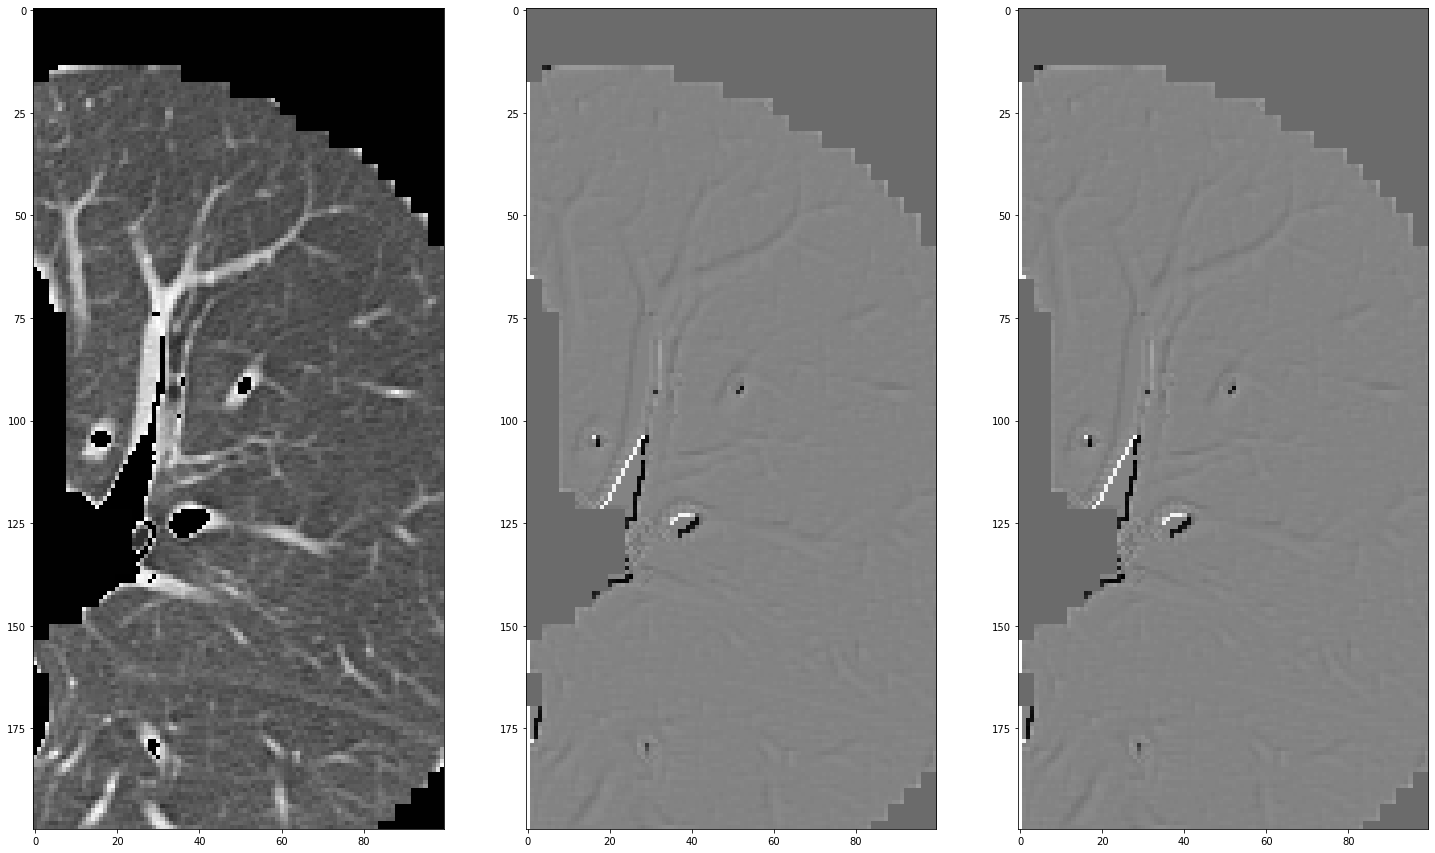

In [144]:
%%time


#foo_cat = equalize_adapthist( fractal ,clip_limit=0.02  )
foo_cat = fractal + 1
sample_min_x = 150
sample_max_x = 350
sample_min_y = 300
sample_max_y = 400
foo_cat = foo_cat[ sample_min_x:sample_max_x , sample_min_y:sample_max_y] 
#min_zero = min(foo_cat.ravel())

N, M = foo_cat.shape
w = 2
n , m = N,M
final_img_q10 = np.zeros( (n,m) )
final_img_2 = np.zeros( (n,m) )
for i in tqdm(range(N)[0:n]):
  for j in range(M)[0:m]:
    if fractal[ sample_min_x + i, sample_min_y + j ] > 0:
      min_x = max( [i - w , 0] )
      max_x = min( [i + w , N] )
      min_y = max( [j - w , 0] )
      max_y = min( [j + w , M] )
      h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=-10)
      h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=2)
      final_img_q10[i,j] = h_10
      final_img_2[i,j] = h_2
      #print(h_10, h_2)
    else:
      h_10 = 0
      h_2 = 0
    #min_x = max( [i - w , 0] )
    #max_x = min( [i + w , N] )
    #min_y = max( [j - w , 0] )
    #max_y = min( [j + w , M] )
    #fig, ax = plt.subplots()
    #ax.imshow(foo_cat[ min_x:max_x , min_y:max_y])

    #h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=-10)
    #h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=2)
    #final_img_q10[i,j] = h_10
    #final_img_2[i,j] = h_2

    #ax.set_title("i = {}, j = {}".format(i,j))

fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,40])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[1].imshow(final_img_q10, cmap ='gray')
ax[2].imshow(final_img_2, cmap ='gray')

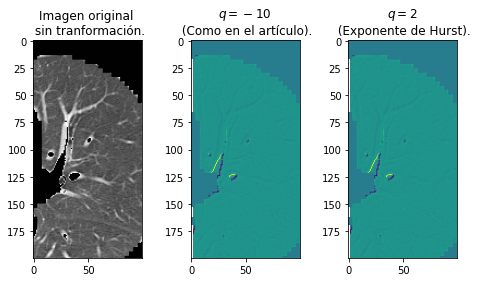

In [146]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([8,4])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[0].set_title("Imagen original \n sin tranformación.")
ax[1].imshow(final_img_q10 )#, cmap ='gray')
ax[1].set_title("$q = -10$ \n (Como en el artículo).")
ax[2].imshow(final_img_2 +1 )#, cmap ='gray')
ax[2].set_title("$q = 2$ \n (Exponente de Hurst).")

fig.savefig("sinequalizador_covid.pdf")

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 38.6 s, sys: 31.9 s, total: 1min 10s
Wall time: 37.8 s


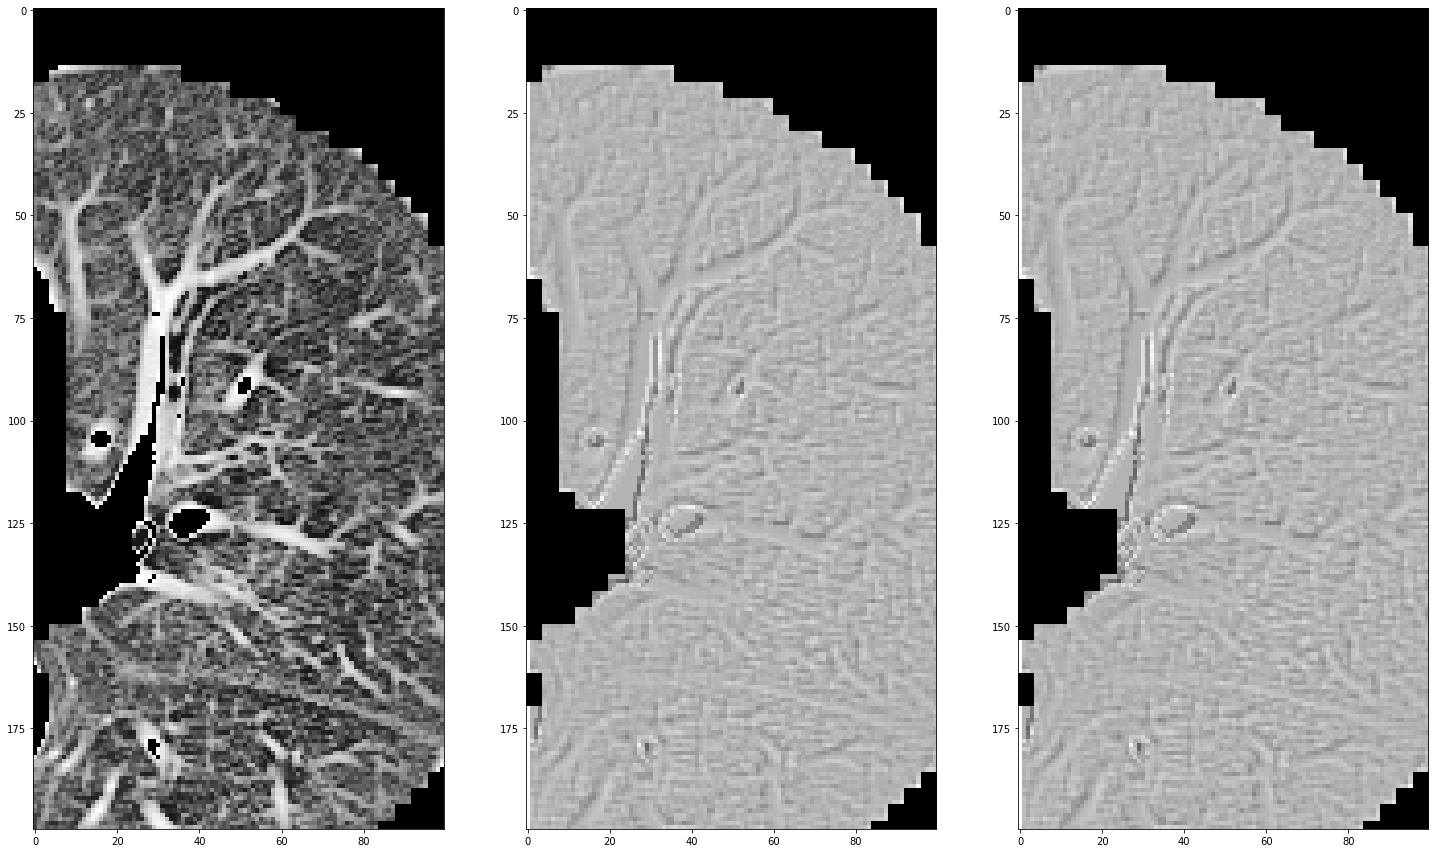

In [153]:
%%time


foo_cat = equalize_adapthist( fractal + 1,clip_limit=0.02  )
#foo_cat = foo_cat + 1
sample_min_x = 150
sample_max_x = 350
sample_min_y = 300
sample_max_y = 400
foo_cat = foo_cat[ sample_min_x:sample_max_x , sample_min_y:sample_max_y] 
#min_zero = min(foo_cat.ravel())

N, M = foo_cat.shape
w = 2
n , m = N,M
final_img_q10 = np.zeros( (n,m) )
final_img_2 = np.zeros( (n,m) )
for i in tqdm(range(N)[0:n]):
  for j in range(M)[0:m]:
    if fractal[ sample_min_x + i, sample_min_y + j ] > 0:
      min_x = max( [i - w , 0] )
      max_x = min( [i + w , N] )
      min_y = max( [j - w , 0] )
      max_y = min( [j + w , M] )
      #print("HAgo algo")
      h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=-10)
      #print("HAgo otro")
      h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y] + 1,min_s=2, max_s=3,q=2)
      final_img_q10[i,j] = h_10
      final_img_2[i,j] = h_2
      #print(h_10, h_2)
    else:
      h_10 = 0
      h_2 = 0
    #min_x = max( [i - w , 0] )
    #max_x = min( [i + w , N] )
    #min_y = max( [j - w , 0] )
    #max_y = min( [j + w , M] )
    #fig, ax = plt.subplots()
    #ax.imshow(foo_cat[ min_x:max_x , min_y:max_y])

    #h_10 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=-10)
    #h_2 = get_h_q_mfdfa(foo_cat[ min_x:max_x , min_y:max_y],min_s=2, max_s=4,q=2)
    #final_img_q10[i,j] = h_10
    #final_img_2[i,j] = h_2

    #ax.set_title("i = {}, j = {}".format(i,j))

fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,40])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[1].imshow(final_img_q10, cmap ='gray')
ax[2].imshow(final_img_2, cmap ='gray')

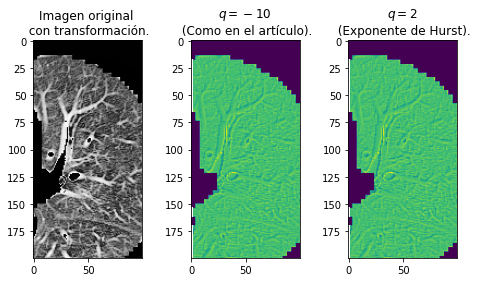

In [154]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([8,4])
ax = axes.ravel()
ax[0].imshow(foo_cat,cmap ='gray')
ax[0].set_title("Imagen original \n con transformación.")
ax[1].imshow(final_img_q10 )#, cmap ='gray')
ax[1].set_title("$q = -10$ \n (Como en el artículo).")
ax[2].imshow(final_img_2 +1 )#, cmap ='gray')
ax[2].set_title("$q = 2$ \n (Exponente de Hurst).")

fig.savefig("conequalizador_covid.pdf")

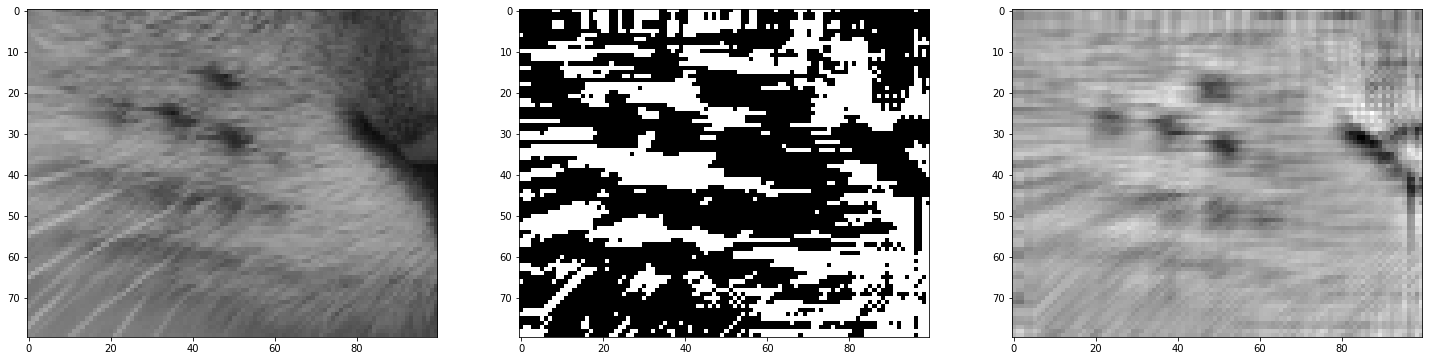

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,40])
ax = axes.ravel()
ax[0].imshow(color.gray2rgb(foo_cat),cmap ='gray')
ax[1].imshow(final_img_q10 > 2.35, cmap ='gray')
ax[2].imshow(final_img_2, cmap ='gray')

(array([2874.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   12.,  726., 5402., 8290.,
        1849.,  227.,   36.]),
 array([0.        , 0.08884658, 0.17769316, 0.26653974, 0.35538631,
        0.44423289, 0.53307947, 0.62192605, 0.71077263, 0.79961921,
        0.88846579, 0.97731237, 1.06615894, 1.15500552, 1.2438521 ,
        1.33269868, 1.42154526, 1.51039184, 1.59923842, 1.688085  ,
        1.77693157, 1.86577815, 1.95462473, 2.04347131, 2.13231789,
        2.22116447, 2.31001105, 2.39885763, 2.4877042 , 2.57655078,
        2.66539736]),
 <a list of 30 Patch objects>)

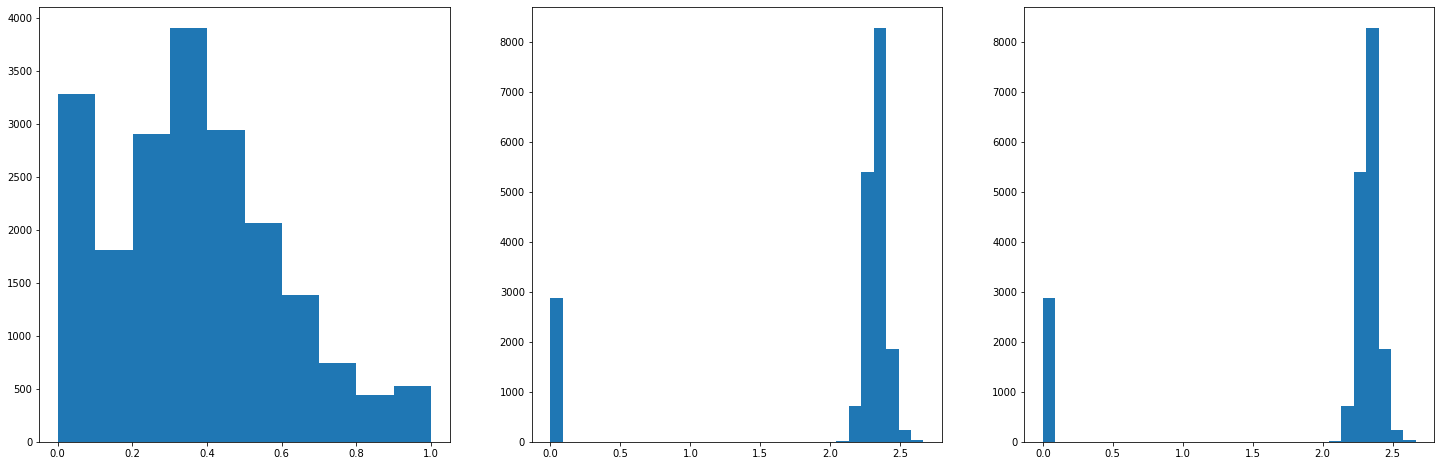

In [69]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches([25,8])
ax = axes.ravel()
ax[0].hist(foo_cat.ravel())
ax[1].hist(final_img_q10.ravel(), bins = 30)
ax[2].hist(final_img_2.ravel(), bins = 30)

# Con archivos DCIM - final

In [31]:
#!pip install dicom
#!pip install pydicom --upgrade
#!pip install pylibjpeg
#!pip install pillow
#!pip install pylibjpeg pylibjpeg-libjpeg pydicom
!pip install tensorflow_io

     |████████████████████████████████| 22.7 MB 2.9 MB/s 
     |████████████████████████████████| 2.1 MB 53.6 MB/s 


In [ ]:
!unzip /content/drive/MyDrive/covid-ct-bronquial-tree/data/COVID-CT-MD.zip -d dcimdata

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pydicom as dicom
import pylibjpeg
import tensorflow as tf
import tensorflow_io as tfio

from natsort import natsorted, ns
from skimage.color import rgb2gray
#import pillow

path_dicom_tar = '/content/drive/MyDrive/covid-ct-bronquial-tree/data/COVID-CT-MD.zip'

path_covid_cases = '/content/dcimdata/COVID-19 Cases'
path_cap_cases = '/content/dcimdata/Cap Cases'
path_normal_cases = '/content/dcimdata/Normal Cases'

list_covid_patients = os.listdir(path_covid_cases)
list_normal_patients = os.listdir(path_normal_cases)

#print(natsorted(list_covid_patients))

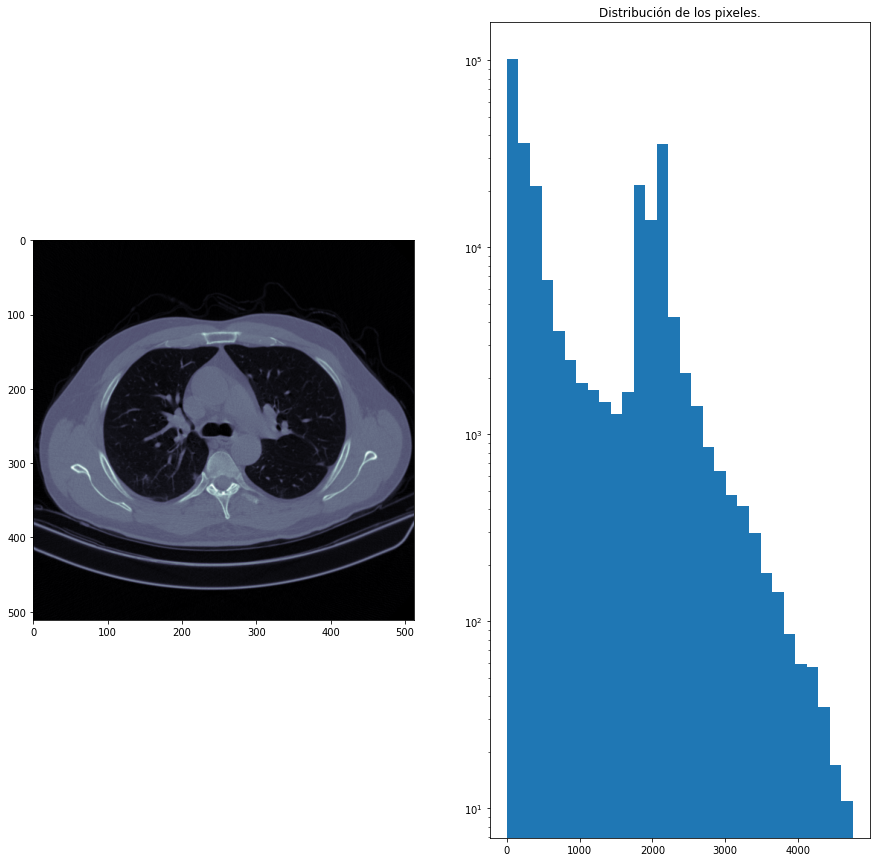

In [56]:
#import pydicom
import pydicom.data
#Vemos el primer paciente
data_patient = '{}/{}'.format(path_covid_cases, list_covid_patients[0])
list_data_patient = natsorted(os.listdir(data_patient))

path_single_file = '{}/{}'.format(data_patient, list_data_patient[50])
#path_single_file

image_bytes = tf.io.read_file(path_single_file)
image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)
image_gray = rgb2gray(image.numpy()[0,:,:,0])

fig, axes = plt.subplots(1,2)
fig.set_size_inches([15,15])
ax = axes.ravel()

ax[0].imshow(image.numpy()[0,:,:,0], cmap= 'bone')
ax[1].set_title('Distribución de los pixeles.')
ax[1].hist(image_gray.ravel(), bins= 30)
ax[1].set_yscale('log')

#foo_file = dicom.dcmread(path_single_file, stop_before_pixels=True)
#foo_file.pixel_array
#pydicom.data.data_manager.get_files(data_patient, list_data_patient[0])[0]
#foo_file.pixel_array